# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer (i.e. BOGO, discount, informational)
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Problem Statement

For this project we want to find out how we can maximize Starbucks profit using the data from the Starbucks App, to do this we need to answer the following questions:
* **Q1:** For the completed offers, what is the distribution of offer types and channels?
* **Q2:** What are the characteristics of customers who complete 50% or more of the offers they view and those who complete less?
* **Q3:** Can we determine which demographic groups respond best to which offer type?


To be able to answer these question we need to perform some analysis on the data.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import math
import json
import time

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [4]:
profile

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,20180604,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,20180713,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,20170126,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,20160307,50000.0


In [5]:
transcript

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


## Assessing the data

In this part I will assess the data for missing values, duplicates, incorrect data type and outliers, I will assess each dataset on its own.

======================================================================================


#### Portfolio dataset

In [6]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
reward        10 non-null int64
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
offer_type    10 non-null object
id            10 non-null object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


There doesn't seem to be anything unusual with the portfolio dataset and it's a small dataset, but the channel attribute is represented in a strange way, and the offer_type could be used as a categorical attribute. Also, the id column name could cause confusion with other columns in other datasets. The duration could be converted to hours.

======================================================================================

#### Profile dataset

In [7]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 17000 non-null int64
id                  17000 non-null object
became_member_on    17000 non-null int64
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [8]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [9]:
profile[profile.income.isnull()&profile.gender.isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


In [10]:
profile.age.value_counts()

118    2175
58      408
53      372
51      363
54      359
       ... 
100      12
96        8
98        5
99        5
101       5
Name: age, Length: 85, dtype: int64

The profile dataset has some missing gender and income values (2175 entries, also whenever there is a missing gender there is a missing income and age is equal to 118) and the became_member_on attribute is not in datetime format. Also, the id column name could cause confusion with other columns in other datasets.

======================================================================================

#### Transcript dataset

In [11]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
person    306534 non-null object
event     306534 non-null object
value     306534 non-null object
time      306534 non-null int64
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


In [12]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


In [13]:
transcript.value.value_counts()

{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}    14983
{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}    14924
{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}    14891
{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}    14835
{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'}    14374
                                                    ...  
{'amount': 439.14}                                      1
{'amount': 42.75}                                       1
{'amount': 650.75}                                      1
{'amount': 943.4}                                       1
{'amount': 44.21}                                       1
Name: value, Length: 5121, dtype: int64

In [14]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [15]:
transcript.time.value_counts()

408    17030
576    17015
504    16822
336    16302
168    16150
       ...  
318      940
330      938
156      914
162      910
150      894
Name: time, Length: 120, dtype: int64

For the transcript the value attribute might cause a problem, and the person column should be renamed to customer_id.

## Cleaning the data

#### Portfolio dataset

In [16]:
# rename the id column to offer_id and change duration from days to hours
portfolio.rename(columns={'id':'offer_id'},inplace=True)
portfolio.duration = portfolio.duration * 24

In [17]:
# find the unique channels
channel_list = []
for chan in portfolio.channels:
    for c in chan:
        if c not in channel_list:
            channel_list.append(c)
print(channel_list)

['email', 'mobile', 'social', 'web']


In [18]:
# Each of these 4 elements needs to have its own column and will remove the channels column
for c in channel_list:
    portfolio[c] = portfolio['channels'].apply(lambda x: 1 if c in x else 0)

In [19]:
portfolio = pd.concat([portfolio, pd.get_dummies(portfolio['offer_type'])],axis=1)

In [20]:
portfolio.drop(['channels','offer_type'],axis=1,inplace=True)
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


#### Profile dataset

In [21]:
profile.rename(columns={'id':'customer_id'},inplace=True)

In [22]:
# Drop the rows with missing gender income
profile.dropna(inplace=True)

In [23]:
profile.became_member_on = profile.became_member_on.apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
gender              14825 non-null object
age                 14825 non-null int64
customer_id         14825 non-null object
became_member_on    14825 non-null datetime64[ns]
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [25]:
profile

,gender,age,customer_id,became_member_on,income
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0
8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0
12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0
...,...,...,...,...,...
16995,F,45,6d5f3a774f3d4714ab0c092238f3a1d7,2018-06-04,54000.0
16996,M,61,2cb4f97358b841b9a9773a7aa05a9d77,2018-07-13,72000.0
16997,M,49,01d26f638c274aa0b965d24cefe3183f,2017-01-26,73000.0
16998,F,83,9dc1421481194dcd9400aec7c9ae6366,2016-03-07,50000.0


#### Transcript dataset

In [26]:
transcript.rename(columns={'person':'customer_id'},inplace=True)

In [27]:
# Convert the dictionaries in value column into columns
start = time.time()
transcript  = pd.concat([transcript, transcript['value'].apply(pd.Series)],axis=1)
print("Total time : {} minutes".format((time.time()-start)/60))

Total time : 1.394792918364207 minutes


In [28]:
transcript

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714,NaN,1.59,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714,NaN,9.53,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714,NaN,3.61,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714,NaN,3.53,NaN,NaN


In [29]:
# See if one of the offer id columns have a value while the other doesn't.
transcript[transcript.offer_id.isnull()&~transcript['offer id'].isnull()]

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
306441,d56386cf344c4829bbf420d1895dca37,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
306450,9b51e8797290403b90d09d864dec4b94,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
306483,84fb57a7fe8045a8bf6236738ee73a0f,offer viewed,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},714,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN
306490,abc4359eb34e4e2ca2349da2ddf771b6,offer viewed,{'offer id': '3f207df678b143eea3cee63160fa8bed'},714,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN


In [30]:
# Merge the two offer id columns into one column.
transcript['offer_id'].fillna(transcript['offer id'], inplace=True)

In [31]:
# Create dummy variables from the event column
transcript = pd.concat([transcript, pd.get_dummies(transcript['event'])],axis=1)

In [32]:
transcript.drop(['value','offer id','event'],axis = 1,inplace=True)

In [33]:
transcript[~transcript.offer_id.isnull()]

,customer_id,time,amount,offer_id,reward,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,0,1,0,0
...,...,...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,3.0,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,0,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,714,NaN,fafdcd668e3743c1bb461111dcafc2a4,2.0,1,0,0,0


I've noticed that raws with 0 offer completion have NaN reward, reward column is the same as the one in portfolio so it should be dropped.

In [34]:
transcript.drop('reward',axis=1,inplace=True)

In [35]:
transcript_offers = transcript[~transcript.offer_id.isnull()].drop('amount',axis=1)
transcript_amount = transcript[transcript.offer_id.isnull()].drop('offer_id',axis=1)

In [36]:
transcript_amount

,customer_id,time,amount,offer completed,offer received,offer viewed,transaction
12654,02c083884c7d45b39cc68e1314fec56c,0,0.83,0,0,0,1
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,34.56,0,0,0,1
12659,54890f68699049c2a04d415abc25e717,0,13.23,0,0,0,1
12670,b2f1cd155b864803ad8334cdf13c4bd2,0,19.51,0,0,0,1
12671,fe97aa22dd3e48c8b143116a8403dd52,0,18.97,0,0,0,1
...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,714,1.59,0,0,0,1
306530,68213b08d99a4ae1b0dcb72aebd9aa35,714,9.53,0,0,0,1
306531,a00058cf10334a308c68e7631c529907,714,3.61,0,0,0,1
306532,76ddbd6576844afe811f1a3c0fbb5bec,714,3.53,0,0,0,1


In [37]:
transcript_offers

,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0


===========================================================================================================================================================
## Analyzing the data
#### Q1: For the completed offers, what is the distribution of offer types and channels?

To answer this question we need to look at the distribution of each offer type and channel.

In [38]:
portfolio

,reward,difficulty,duration,offer_id,email,mobile,social,web,bogo,discount,informational
0,10,10,168,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,96,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,240,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,72,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,120,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,168,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


In [39]:
transcript_offers

,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0
...,...,...,...,...,...,...,...
306497,a6f84f4e976f44508c358cc9aba6d2b3,714,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,0
306506,b895c57e8cd047a8872ce02aa54759d6,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0
306507,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0
306509,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0


In [40]:
merged_portfolio_transcript = pd.merge(transcript_offers,portfolio, how='right', on='offer_id')
merged_portfolio_transcript

,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,5,168,1,1,0,1,1,0,0
1,ebe7ef46ea6f4963a7dd49f501b26779,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,5,168,1,1,0,1,1,0,0
2,f082d80f0aac47a99173ba8ef8fc1909,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,5,168,1,1,0,1,1,0,0
3,c0d210398dee4a0895b24444a5fcd1d2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,5,168,1,1,0,1,1,0,0
4,57dd18ec5ddc46828afb81ec5977bef2,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,5,5,168,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167576,642b6f1bf61040efb73e1859cf00e79e,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,0,0,72,1,1,1,0,0,0,1
167577,5a3f7fcb450a4cb693ab5267b4d49b40,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,0,0,72,1,1,1,0,0,0,1
167578,ec1761735b034ae8874bc979f0cd5862,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,0,0,72,1,1,1,0,0,0,1
167579,d56386cf344c4829bbf420d1895dca37,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,0,0,0,72,1,1,1,0,0,0,1


In [41]:
for col in ['email','mobile','social','web']:
    print(col)
    print(merged_portfolio_transcript[col].sum())
    print(merged_portfolio_transcript[col].mean())
    print()

email
167581
1.0

mobile
153830
0.9179441583473067

social
110100
0.6569957214720046

web
135214
0.8068575793198512



In [42]:
merged_portfolio_transcript.email.mean()

1.0

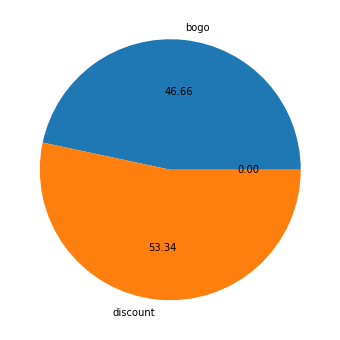

In [43]:
completed_offers = merged_portfolio_transcript[merged_portfolio_transcript['offer completed']==1][['bogo','discount','informational','email','mobile','social','web']]
completed_offers[['bogo','discount','informational']].mean().plot(kind='pie', autopct='%.2f',figsize=(6,6));
plt.ylabel("")
plt.show();

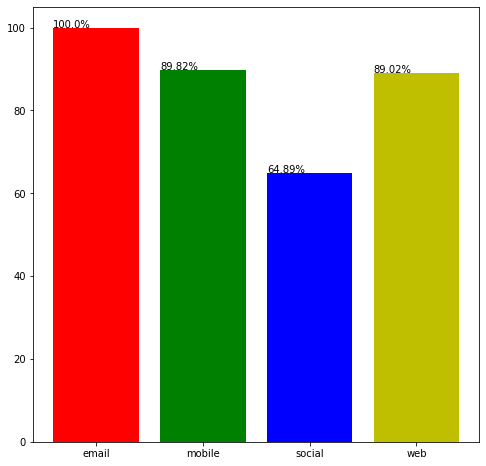

In [44]:

fig, ax = plt.subplots(figsize = (8,8))
ax.bar(['email','mobile','social','web'],(completed_offers[['email','mobile','social','web']].mean()*100),color=['r', 'g', 'b', 'y'])
plt.title('')
plt.ylabel("")
for p in ax.patches:
    ax.annotate("{}%".format(round(p.get_height(),2)), (p.get_x(), p.get_height()))
plt.show();

As we can see from the two graphs above we can see that more than half of completed offers were discount offers.

For the channels: even thougn email has 100% completion rate, this information is not useful since all of the offers were sent through email(completed or not), however we can see that almost 90% of the completed offers were **mobile** and **web**. 65% of the completed offers were through **social**.

==============================================================================================================================================================


#### Q2: What are the characteristics of customers who complete more than 50% of the offers they view and those who complete less?

To answer this question, we need to separate the profile dataset into three parts:
1. Customers who  complete 50% or more of offers they viewed.
2. Customers who  complete less than 50% of offers they've viewed or customers who completed an offer but didn't view it.

In [45]:
# First we will merge the profile dataset with the transcript_offers dataset.
merged_profile_transcript = pd.merge(transcript_offers,profile, how='left', on='customer_id')
merged_profile_transcript

,customer_id,time,offer_id,offer completed,offer received,offer viewed,transaction,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,F,75.0,2017-05-09,100000.0
1,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,NaN,NaN,NaT,NaN
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,M,68.0,2018-04-26,70000.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,0,1,0,0,NaN,NaN,NaT,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0,1,0,0,NaN,NaN,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...
167576,a6f84f4e976f44508c358cc9aba6d2b3,714,2298d6c36e964ae4a3e7e9706d1fb8c2,1,0,0,0,NaN,NaN,NaT,NaN
167577,b895c57e8cd047a8872ce02aa54759d6,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,NaN,NaN,NaT,NaN
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,0,F,60.0,2017-09-08,64000.0
167579,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,0,M,39.0,2018-06-27,39000.0


In [46]:
merged_profile_transcript.dropna(inplace=True)
merged_profile_transcript.drop('transaction',axis=1,inplace=True)
merged_profile_transcript

,customer_id,time,offer_id,offer completed,offer received,offer viewed,gender,age,became_member_on,income
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,F,75.0,2017-05-09,100000.0
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,M,68.0,2018-04-26,70000.0
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,M,65.0,2018-02-09,53000.0
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0,M,58.0,2017-11-11,51000.0
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,F,61.0,2017-09-11,57000.0
...,...,...,...,...,...,...,...,...,...,...
167574,84fb57a7fe8045a8bf6236738ee73a0f,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,F,64.0,2017-06-15,113000.0
167575,abc4359eb34e4e2ca2349da2ddf771b6,714,3f207df678b143eea3cee63160fa8bed,0,0,1,M,51.0,2014-08-04,68000.0
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,F,60.0,2017-09-08,64000.0
167579,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,M,39.0,2018-06-27,39000.0


In [47]:
merged_profile_transcript['offer completed'].mean()

0.2180303081213669

In [48]:
# to simplify the became_member_on we will convert it to show month and year only.
merged_profile_transcript['year_month'] = merged_profile_transcript['became_member_on'].dt.strftime('%b-%Y')
merged_profile_transcript

,customer_id,time,offer_id,offer completed,offer received,offer viewed,gender,age,became_member_on,income,year_month
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,F,75.0,2017-05-09,100000.0,May-2017
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,M,68.0,2018-04-26,70000.0,Apr-2018
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,M,65.0,2018-02-09,53000.0,Feb-2018
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0,M,58.0,2017-11-11,51000.0,Nov-2017
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,F,61.0,2017-09-11,57000.0,Sep-2017
...,...,...,...,...,...,...,...,...,...,...,...
167574,84fb57a7fe8045a8bf6236738ee73a0f,714,5a8bc65990b245e5a138643cd4eb9837,0,0,1,F,64.0,2017-06-15,113000.0,Jun-2017
167575,abc4359eb34e4e2ca2349da2ddf771b6,714,3f207df678b143eea3cee63160fa8bed,0,0,1,M,51.0,2014-08-04,68000.0,Aug-2014
167578,8dda575c2a1d44b9ac8e8b07b93d1f8e,714,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,1,F,60.0,2017-09-08,64000.0,Sep-2017
167579,8431c16f8e1d440880db371a68f82dd0,714,fafdcd668e3743c1bb461111dcafc2a4,1,0,0,M,39.0,2018-06-27,39000.0,Jun-2018


In [49]:
# Group by the customers and offers to find each customer interaction with different offers
customer_interaction = merged_profile_transcript.groupby(['customer_id','offer_id'],as_index = False).sum()
customer_interaction

,customer_id,offer_id,time,offer completed,offer received,offer viewed,age,income
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1152,1,1,0,66.0,144000.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,708,0,1,1,66.0,144000.0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,360,0,1,1,66.0,144000.0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1278,1,1,1,99.0,216000.0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1572,1,1,1,99.0,216000.0
...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,1476,2,2,2,204.0,204000.0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,540,1,1,1,135.0,186000.0
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,4044,3,3,3,405.0,558000.0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1542,1,1,1,135.0,186000.0


In [50]:
customer_interaction['diff_viewed_completed'] = customer_interaction['offer viewed'].astype(int)-customer_interaction['offer completed'].astype(int)
customer_interaction['complete_not_viewed'] = np.where(customer_interaction['diff_viewed_completed']>=0, 0, customer_interaction['diff_viewed_completed'].abs())
customer_interaction['viewed_complete'] = customer_interaction['offer completed'].astype(int)-customer_interaction['complete_not_viewed'].astype(int)
customer_interaction.drop(['income','age','time'],axis=1,inplace=True)
customer_interaction

,customer_id,offer_id,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,-1,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,0,1
...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,0,0,2
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0,1
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,0,3
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,0,1


In [51]:
customer_interaction_mean = customer_interaction.groupby('customer_id').mean()
customer_interaction_mean['viewed_complete_ratio'] = customer_interaction_mean['viewed_complete'] / customer_interaction_mean['offer viewed']
customer_interaction_mean

,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,viewed_complete_ratio
customer_id,,,,,,,
0009655768c64bdeb2e877511632db8f,0.60,1.000000,0.800000,0.200000,0.20,0.40,0.500000
0011e0d4e6b944f998e987f904e8c1e5,0.60,1.000000,1.000000,0.400000,0.00,0.60,0.600000
0020c2b971eb4e9188eac86d93036a77,0.75,1.250000,0.750000,0.000000,0.25,0.50,0.666667
0020ccbbb6d84e358d3414a3ff76cffd,0.75,1.000000,1.000000,0.250000,0.00,0.75,0.750000
003d66b6608740288d6cc97a6903f4f0,0.75,1.250000,1.000000,0.250000,0.25,0.50,0.500000
...,...,...,...,...,...,...,...
fff3ba4757bd42088c044ca26d73817a,0.75,1.500000,0.750000,0.000000,0.25,0.50,0.666667
fff7576017104bcc8677a8d63322b5e1,0.75,1.250000,1.000000,0.250000,0.25,0.50,0.500000
fff8957ea8b240a6b5e634b6ee8eafcf,0.00,1.000000,0.666667,0.666667,0.00,0.00,0.000000


In [52]:
customer_interaction_mean.viewed_complete_ratio.unique()

array([0.5       , 0.6       , 0.66666667, 0.75      , 1.        ,
       0.        , 0.25      , 0.8       , 0.33333333, 0.2       ,
       0.8       , 0.33333333, 0.4       , 0.4       , 0.83333333,
       0.66666667, 0.2       , 0.75      ,        nan, 0.16666667,
       0.16666667])

In [53]:
customer_interaction_mean.viewed_complete_ratio.fillna(0,inplace=True)
customer_interaction_mean_full = pd.merge(customer_interaction_mean,profile,on='customer_id',how='left')
customer_interaction_mean_full

,customer_id,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,viewed_complete_ratio,gender,age,became_member_on,income
0,0009655768c64bdeb2e877511632db8f,0.60,1.000000,0.800000,0.200000,0.20,0.40,0.500000,M,33,2017-04-21,72000.0
1,0011e0d4e6b944f998e987f904e8c1e5,0.60,1.000000,1.000000,0.400000,0.00,0.60,0.600000,O,40,2018-01-09,57000.0
2,0020c2b971eb4e9188eac86d93036a77,0.75,1.250000,0.750000,0.000000,0.25,0.50,0.666667,F,59,2016-03-04,90000.0
3,0020ccbbb6d84e358d3414a3ff76cffd,0.75,1.000000,1.000000,0.250000,0.00,0.75,0.750000,F,24,2016-11-11,60000.0
4,003d66b6608740288d6cc97a6903f4f0,0.75,1.250000,1.000000,0.250000,0.25,0.50,0.500000,F,26,2017-06-21,73000.0
...,...,...,...,...,...,...,...,...,...,...,...,...
14815,fff3ba4757bd42088c044ca26d73817a,0.75,1.500000,0.750000,0.000000,0.25,0.50,0.666667,F,69,2015-09-20,83000.0
14816,fff7576017104bcc8677a8d63322b5e1,0.75,1.250000,1.000000,0.250000,0.25,0.50,0.500000,M,71,2017-10-31,73000.0
14817,fff8957ea8b240a6b5e634b6ee8eafcf,0.00,1.000000,0.666667,0.666667,0.00,0.00,0.000000,M,71,2018-02-18,56000.0
14818,fffad4f4828548d1b5583907f2e9906b,1.00,1.333333,1.333333,0.333333,0.00,1.00,0.750000,M,34,2017-01-23,34000.0


In [54]:
above_50_or_equal = customer_interaction_mean_full[customer_interaction_mean_full.viewed_complete_ratio>=0.5]
below_50 = customer_interaction_mean_full[customer_interaction_mean_full.viewed_complete_ratio<0.5]

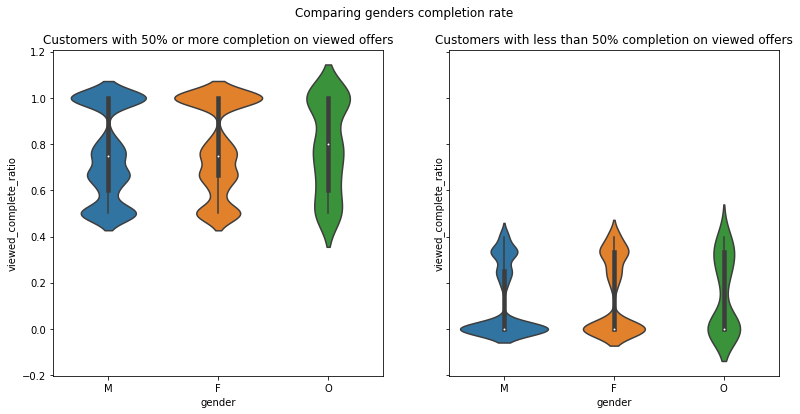

In [55]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(13,6))
fig.suptitle("Comparing genders completion rate")
sb.violinplot(data = above_50_or_equal, x = 'gender', y = 'viewed_complete_ratio',ax=ax1,order=['M','F','O'])
ax1.set_title("Customers with 50% or more completion on viewed offers")
sb.violinplot(data = below_50, x = 'gender', y = 'viewed_complete_ratio',ax=ax2,order=['M','F','O'])
ax2.set_title("Customers with less than 50% completion on viewed offers");

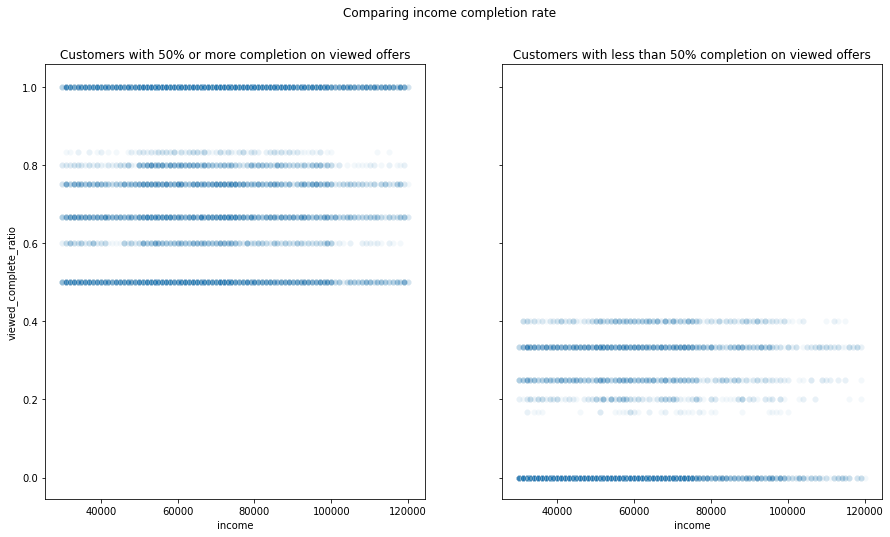

In [56]:
fig, (ax3, ax4) = plt.subplots(1, 2, sharey=True,figsize=(15,8))
fig.suptitle("Comparing income completion rate")
sb.scatterplot(data = above_50_or_equal, x = 'income', y = 'viewed_complete_ratio',ax=ax3,alpha=0.05)
ax3.set_title("Customers with 50% or more completion on viewed offers")
sb.scatterplot(data = below_50, x = 'income', y = 'viewed_complete_ratio',ax=ax4,alpha=0.05)
ax4.set_title("Customers with less than 50% completion on viewed offers");

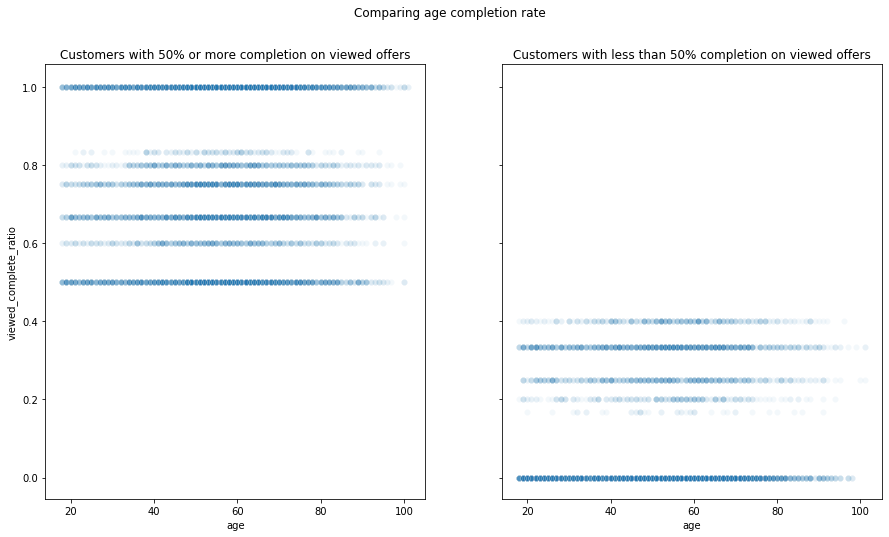

In [57]:
fig, (ax5, ax6) = plt.subplots(1, 2, sharey=True,figsize=(15,8))
fig.suptitle("Comparing age completion rate")
sb.scatterplot(data = above_50_or_equal, x = 'age', y = 'viewed_complete_ratio',ax=ax5,alpha=0.05)
ax5.set_title("Customers with 50% or more completion on viewed offers")
sb.scatterplot(data = below_50, x = 'age', y = 'viewed_complete_ratio',ax=ax6,alpha=0.05)
ax6.set_title("Customers with less than 50% completion on viewed offers");

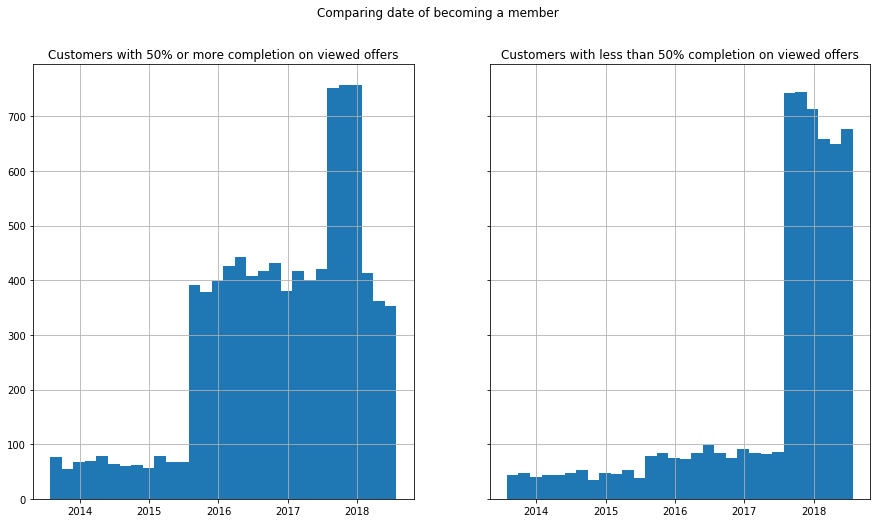

In [58]:
fig, (ax7, ax8) = plt.subplots(1, 2, sharey=True,figsize=(15,8))
fig.suptitle("Comparing date of becoming a member")
above_50_or_equal.became_member_on.hist(ax=ax7,bins=30)
ax7.set_title("Customers with 50% or more completion on viewed offers")
below_50.became_member_on.hist(ax=ax8,bins=30)
ax8.set_title("Customers with less than 50% completion on viewed offers");

================================================================================================================================================================
#### Q3: Can we determine which demographic groups respond best to which offer type?

To answer this question, we need to merge all the data together prepare it for training, then we need to build a training model to predict which is the best offer for a given demographic.

In [59]:
full_df = pd.merge(customer_interaction,profile,on='customer_id',how='left')
full_df = pd.merge(full_df,portfolio,on='offer_id',how='left')
full_df

,customer_id,offer_id,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,gender,age,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,-1,1,0,M,33,...,2,10,168,1,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,M,33,...,0,0,96,1,1,0,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,M,33,...,0,0,72,1,1,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,0,1,M,33,...,5,5,120,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,0,1,M,33,...,2,10,240,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,0,0,2,M,34,...,5,5,120,1,1,1,1,1,0,0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0,1,F,45,...,5,20,240,1,0,0,1,0,1,0
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,0,3,F,45,...,2,10,168,1,1,0,1,0,1,0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,0,1,F,45,...,5,5,168,1,1,0,1,1,0,0


In [60]:
full_df['viewed_complete'] = np.where(full_df['viewed_complete']>0,1,0)
full_df

,customer_id,offer_id,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,gender,age,...,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,-1,1,0,M,33,...,2,10,168,1,1,0,1,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,M,33,...,0,0,96,1,1,0,1,0,0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,M,33,...,0,0,72,1,1,1,0,0,0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,0,1,M,33,...,5,5,120,1,1,1,1,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,0,1,M,33,...,2,10,240,1,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,0,0,1,M,34,...,5,5,120,1,1,1,1,1,0,0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0,1,F,45,...,5,20,240,1,0,0,1,0,1,0
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,0,1,F,45,...,2,10,168,1,1,0,1,0,1,0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,0,1,F,45,...,5,5,168,1,1,0,1,1,0,0


In [61]:
full_df.describe()

,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,age,income,reward,difficulty,duration,email,mobile,social,web,bogo,discount,informational
count,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.0,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000,55222.000000
mean,0.587519,1.204248,0.902901,0.315382,0.100014,0.425537,54.349969,65388.595125,4.204737,7.718554,156.197747,1.0,0.898808,0.599181,0.799337,0.399515,0.400547,0.199938
std,0.647818,0.453029,0.616462,0.732477,0.321355,0.494429,17.392733,21626.373809,3.402301,5.547981,52.935753,0.0,0.301585,0.490069,0.400500,0.489803,0.490014,0.399957
min,0.000000,1.000000,0.000000,-3.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,42.000000,49000.000000,2.000000,5.000000,120.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,55.000000,63000.000000,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,66.000000,80000.000000,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
max,4.000000,5.000000,5.000000,5.000000,3.000000,1.000000,101.000000,120000.000000,10.000000,20.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Features Engineering


In [62]:
# Convert the categorical values to 0 and 1
full_df['age_teens'] = np.where(full_df['age']<20,1,0)
full_df['age_20s'] = np.where((full_df['age']<30)&(full_df['age']>=20),1,0)
full_df['age_30s'] = np.where((full_df['age']<40)&(full_df['age']>=30),1,0)
full_df['age_40s'] = np.where((full_df['age']<50)&(full_df['age']>=40),1,0)
full_df['age_50s'] = np.where((full_df['age']<60)&(full_df['age']>=50),1,0)
full_df['age_60s'] = np.where((full_df['age']<70)&(full_df['age']>=60),1,0)
full_df['age_elderly'] = np.where(full_df['age']>=70,1,0)

full_df['income_low'] = np.where((full_df['income']<48000),1,0)
full_df['income_low_mid'] = np.where((full_df['income']<66000)&(full_df['income']>=48000),1,0)
full_df['income_mid'] = np.where((full_df['income']<84000)&(full_df['income']>=66000),1,0)
full_df['income_high_mid'] = np.where((full_df['income']<102000)&(full_df['income']>=84000),1,0)
full_df['income_high'] = np.where(full_df['income']>=102000,1,0)

full_df = pd.concat([full_df, pd.get_dummies(full_df['gender'],prefix='gender')],axis=1)
full_df = pd.concat([full_df, pd.get_dummies(full_df['duration'],prefix='duration')],axis=1)
# full_df = pd.concat([full_df, pd.get_dummies(full_df['reward'],prefix='reward')],axis=1)
# full_df = pd.concat([full_df, pd.get_dummies(full_df['difficulty'],prefix='difficulty')],axis=1)

full_df

,customer_id,offer_id,offer completed,offer received,offer viewed,diff_viewed_completed,complete_not_viewed,viewed_complete,gender,age,...,income_high_mid,income_high,gender_F,gender_M,gender_O,duration_72,duration_96,duration_120,duration_168,duration_240
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1,1,0,-1,1,0,M,33,...,0,0,0,1,0,0,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,M,33,...,0,0,0,1,0,0,1,0,0,0
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,1,1,1,0,0,M,33,...,0,0,0,1,0,1,0,0,0,0
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,0,0,1,M,33,...,0,0,0,1,0,0,0,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,0,0,1,M,33,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,0,0,1,M,34,...,0,0,0,1,0,0,0,1,0,0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,0,0,1,F,45,...,0,0,1,0,0,0,0,0,0,1
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,0,0,1,F,45,...,0,0,1,0,0,0,0,0,1,0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0,0,1,F,45,...,0,0,1,0,0,0,0,0,1,0


In [63]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55222 entries, 0 to 55221
Data columns (total 42 columns):
customer_id              55222 non-null object
offer_id                 55222 non-null object
offer completed          55222 non-null uint8
offer received           55222 non-null uint8
offer viewed             55222 non-null uint8
diff_viewed_completed    55222 non-null int32
complete_not_viewed      55222 non-null int32
viewed_complete          55222 non-null int32
gender                   55222 non-null object
age                      55222 non-null int64
became_member_on         55222 non-null datetime64[ns]
income                   55222 non-null float64
reward                   55222 non-null int64
difficulty               55222 non-null int64
duration                 55222 non-null int64
email                    55222 non-null int64
mobile                   55222 non-null int64
social                   55222 non-null int64
web                      55222 non-null int64
bog

In [64]:
full_df_completed = full_df.query('viewed_complete == 1').drop(['gender','age','reward','duration','difficulty','became_member_on',
                                                                'income','diff_viewed_completed','complete_not_viewed','viewed_complete'],axis=1)
full_df_completed

,customer_id,offer_id,offer completed,offer received,offer viewed,email,mobile,social,web,bogo,...,income_high_mid,income_high,gender_F,gender_M,gender_O,duration_72,duration_96,duration_120,duration_168,duration_240
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,1,1,1,0,...,0,0,0,1,0,0,0,0,0,1
5,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
6,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,1,1,1,0,...,0,0,0,0,1,0,0,0,1,0
9,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,0,1,1,...,0,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55217,fffad4f4828548d1b5583907f2e9906b,f19421c1d4aa40978ebb69ca19b0e20d,2,2,2,1,1,1,1,1,...,0,0,0,1,0,0,0,1,0,0
55218,ffff82501cea40309d5fdd7edcca4a07,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,1,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,1
55219,ffff82501cea40309d5fdd7edcca4a07,2906b810c7d4411798c6938adc9daaa5,3,3,3,1,1,0,1,0,...,0,0,1,0,0,0,0,0,1,0
55220,ffff82501cea40309d5fdd7edcca4a07,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,1,1,0,1,1,...,0,0,1,0,0,0,0,0,1,0


In [65]:
full_df.std()==0

offer completed          False
offer received           False
offer viewed             False
diff_viewed_completed    False
complete_not_viewed      False
viewed_complete          False
age                      False
income                   False
reward                   False
difficulty               False
duration                 False
email                     True
mobile                   False
social                   False
web                      False
bogo                     False
discount                 False
informational            False
age_teens                False
age_20s                  False
age_30s                  False
age_40s                  False
age_50s                  False
age_60s                  False
age_elderly              False
income_low               False
income_low_mid           False
income_mid               False
income_high_mid          False
income_high              False
gender_F                 False
gender_M                 False
gender_O

#### Model Training

In [78]:
X = full_df_completed[['age_teens','age_elderly','age_20s','age_30s','age_40s','age_50s','age_60s','income_low','income_low_mid'
                      ,'income_mid','income_high_mid','income_high','gender_F','gender_M','gender_O','mobile','social','web'
                      ,'duration_72','duration_96','duration_120','duration_168','duration_240']]
y = full_df_completed['bogo']

# Use train test split to split your data 
# Use a test size of 15% and a random state of 10
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

# Instantiate your decision tree model
model = AdaBoostClassifier(DecisionTreeClassifier())

# Fit the model to the training data.
model.fit(X_train,y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

#Calculate the accuracy and assign it to the variable acc on the test data.
acc = accuracy_score(y_test,y_pred)
print('Accuracy {}%'.format(acc*100))

Accuracy 89.76595744680851%


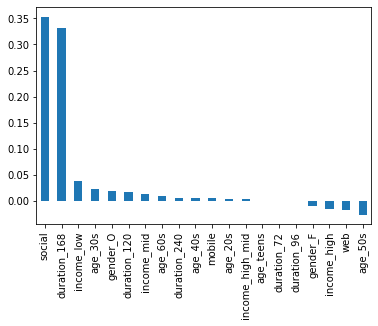

In [79]:
important_features = pd.Series(data=model.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False).head(20).plot(kind='bar');

In [80]:
X = full_df_completed[['age_teens','age_elderly','age_20s','age_30s','age_40s','age_50s','age_60s','income_low','income_low_mid'
                      ,'income_mid','income_high_mid','income_high','gender_F','gender_M','gender_O','mobile','social','web'
                      ,'duration_72','duration_96','duration_120','duration_168','duration_240']]
y = full_df_completed['discount']

# Use train test split to split your data 
# Use a test size of 15% and a random state of 10
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

# Instantiate your decision tree model
model = AdaBoostClassifier(DecisionTreeClassifier())

# Fit the model to the training data.
model.fit(X_train,y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

#Calculate the accuracy and assign it to the variable acc on the test data.
acc = accuracy_score(y_test,y_pred)
print('Accuracy {}%'.format(acc*100))

Accuracy 89.68085106382979%


C:\Users\osamaDesktop\Anaconda3\lib\site-packages\sklearn\tree\tree.py:527: RuntimeWarning: invalid value encountered in true_divide
  return self.tree_.compute_feature_importances()


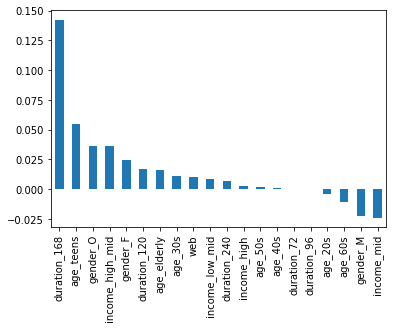

In [81]:
important_features = pd.Series(data=model.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False).head(20).plot(kind='bar');